In [ ]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
from skimage import io
import time
import numpy as np
import imageio as iio

torch.cuda.empty_cache()

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
print(torch.__version__)

In [2]:
############create npy for classes################
with open('classes.npy', 'wb') as f:
 label = np.array([[128,0,0],[0,0,0],[0,0,0]],dtype='i')
 print(label)
 np.save(f,label)

[[128   0   0]
 [  0   0   0]
 [  0   0   0]]


In [3]:
def rgba2rgb( rgba, background=(255,255,255) ):
    row, col, ch = rgba.shape

    if ch == 3:
        return rgba

    assert ch == 4, 'RGBA image has 4 channels.'

    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]

    a = np.asarray( a, dtype='float32' ) / 255.0

    R, G, B = background

    rgb[:,:,0] = r * a + (1.0 - a) * R
    rgb[:,:,1] = g * a + (1.0 - a) * G
    rgb[:,:,2] = b * a + (1.0 - a) * B

    return np.asarray( rgb, dtype='uint8' )

In [4]:
############create class and load data ################
class SegData(Dataset):
    @staticmethod
    def getLabeled(img_name, lbl_dir):
      
        #Returns labeled image filename
        index = img_name.find('.png')
        img_lbl_dir = os.path.join(lbl_dir, (img_name[:index] + '_L' + img_name[index:]))
        return img_lbl_dir

    

    def one_Hot(self, image):
        output_shape = (image.shape[0], image.shape[1], self.classes.shape[0])
        output = np.zeros(output_shape)
        for c in range(self.classes.shape[0]):
            label = np.nanmin(self.classes[c] == image, axis=2) 
            output[:, :, c] = label
        return output
    
    def __init__(self, classes, raw_dir, lbl_dir, transform=None):
        self.classes = classes      
        self.raw_dir = raw_dir     
        self.lbl_dir = lbl_dir     
        self.transform = transform     
        self.list_img = os.listdir(self.raw_dir)
      
        
    def __len__(self):
        return len(self.list_img)

    def __getitem__(self, idx):
        img_raw_name = self.list_img[idx]
        img_raw_dir = os.path.join(self.raw_dir, img_raw_name)
        image_raw = io.imread(img_raw_dir)
        img_lbl_dir = self.getLabeled(img_raw_name, self.lbl_dir)
        image_label = io.imread(img_lbl_dir)
        label = self.one_Hot(image_label)
        
        if self.transform:
            image_raw = self.transform(image_raw)
            label = self.transform(label)

        data = (image_raw, label)
        
            
        return data

    

In [5]:
##Load the RGB data
classes = np.load('classes.npy')

raw_dir = os.path.join(os.getcwd(), 'data_rotation_translation/images')
lbl_dir = os.path.join(os.getcwd(), 'data_rotation_translation/labels')

print(raw_dir)
print(lbl_dir)


transform = transforms.Compose([transforms.ToTensor()
                                ,transforms.Resize((256,256))])

trainset = SegData(classes, raw_dir, lbl_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, num_workers=1)

/home/acp/Downloads/cnn/encdec/sensor_fusion_cnn/data_rotation_translation/images
/home/acp/Downloads/cnn/encdec/sensor_fusion_cnn/data_rotation_translation/labels


In [6]:
def set_device():

# check if CUDA is available
   if torch.cuda.is_available():
        dev = "cuda:0"
   else:
        dev = "cpu"
   return torch.device(dev)  
set_device()

device(type='cuda', index=0)

image  torch.Size([1, 3, 256, 256])
label  torch.Size([1, 3, 256, 256])


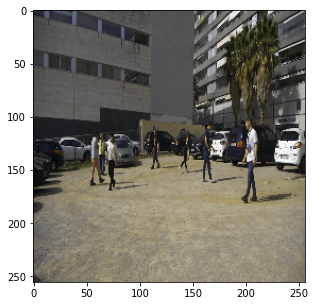

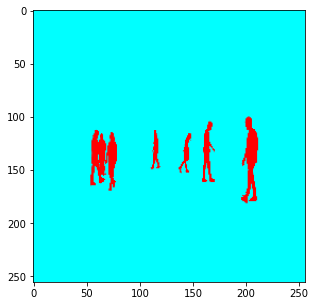

In [7]:
sample = next(iter(trainset))
data = train_loader
batch = next(iter(data))

image,label = batch
    
print("image ", image.shape)
print("label ", label.shape)


grid = torchvision.utils.make_grid(image, nrow=1)
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(grid,(1,2,0)))


grid = torchvision.utils.make_grid(label, nrow=1)
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(grid,(1,2,0)))



In [8]:
##Load the lidar data
classes = np.load('classes.npy')

lidar_dir = os.path.join(os.getcwd(), 'data_rotation_translation/lidar')
lbl_dir = os.path.join(os.getcwd(), 'data_rotation_translation/labels')

print(lidar_dir)
print(lbl_dir)


transform = transforms.Compose([transforms.ToTensor()
                                ,transforms.Resize((256,256))])

lidarset = SegData(classes, lidar_dir, lbl_dir, transform=transform)

lidar_loader = torch.utils.data.DataLoader(lidarset, batch_size=1, shuffle=False, num_workers=4)

/home/acp/Downloads/cnn/encdec/sensor_fusion_cnn/data_rotation_translation/lidar
/home/acp/Downloads/cnn/encdec/sensor_fusion_cnn/data_rotation_translation/labels


image  torch.Size([1, 3, 256, 256])
label  torch.Size([1, 3, 256, 256])


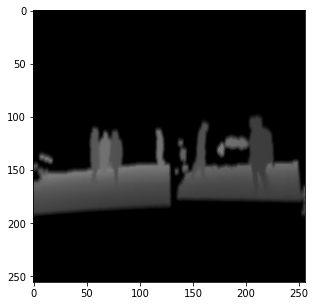

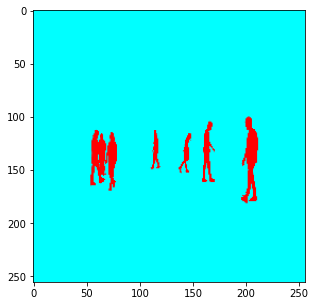

In [9]:
###Visualize Lidar

lidar_data = lidar_loader
lidar_batch = next(iter(lidar_data))
lidar_image,label = lidar_batch
    
print("image ", lidar_image.shape)
print("label ", label.shape)
    
grid = torchvision.utils.make_grid(lidar_image, nrow=2)
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(grid,(1,2,0)))


grid = torchvision.utils.make_grid(label, nrow=2)
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(grid,(1,2,0)))

In [10]:
##Load the Radar data
classes = np.load('classes.npy')
radar_dir = os.path.join(os.getcwd(), 'data_rotation_translation/radar')
lbl_dir = os.path.join(os.getcwd(), 'data_rotation_translation/labels')

print(radar_dir)
print(lbl_dir)


transform = transforms.Compose([transforms.ToTensor()
                                ,transforms.Resize((256,256))])

radar_trainset = SegData(classes, radar_dir, lbl_dir, transform=transform)

radar_loader = torch.utils.data.DataLoader(radar_trainset, batch_size=1, shuffle=False, num_workers=1)

/home/acp/Downloads/cnn/encdec/sensor_fusion_cnn/data_rotation_translation/radar
/home/acp/Downloads/cnn/encdec/sensor_fusion_cnn/data_rotation_translation/labels


image  torch.Size([1, 3, 256, 256])
label  torch.Size([1, 3, 256, 256])


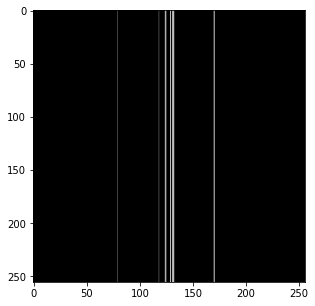

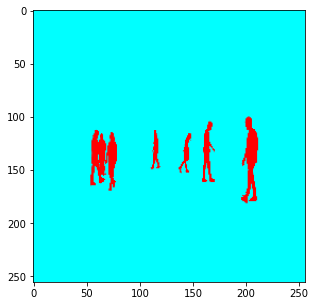

In [11]:
###Visualize the radar images
radar_data = radar_loader
radar_batch = next(iter(radar_data))
radar_image,radar_label = radar_batch
    
print("image ", radar_image.shape)
print("label ", radar_label.shape)


grid = torchvision.utils.make_grid(radar_image, nrow=2)
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(grid,(1,2,0)))


grid = torchvision.utils.make_grid(radar_label, nrow=2)
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(grid,(1,2,0)))

In [12]:
#####----BUILD THE MODEL----#####
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #ENCODING
        self.conv11 = nn.Conv2d(3, 64, 3, padding=1)
        self.BNEn11 = nn.BatchNorm2d(64,momentum=0.9)
       
        self.conv12 = nn.Conv2d(64, 64, 3, padding=1)
        self.BNEn12 = nn.BatchNorm2d(64,momentum=0.9)
        
        self.conv21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.BNEn21 = nn.BatchNorm2d(128,momentum=0.9)
     
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn22 = nn.BatchNorm2d(128,momentum=0.9)
        
        self.conv31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.BNEn31 = nn.BatchNorm2d(256,momentum=0.9)
     
        self.conv32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn32 = nn.BatchNorm2d(256,momentum=0.9)
        self.conv33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn33 = nn.BatchNorm2d(256,momentum=0.9)

        self.conv41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.BNEn41 = nn.BatchNorm2d(512,momentum=0.9)
      
        self.conv42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn42 = nn.BatchNorm2d(512,momentum=0.9)
        self.conv43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn43 = nn.BatchNorm2d(512,momentum=0.9)
        
        self.conv51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn51 = nn.BatchNorm2d(512,momentum=0.9)
     
        self.conv52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn52 = nn.BatchNorm2d(512,momentum=0.9)
        self.conv53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn53 = nn.BatchNorm2d(512,momentum=0.9)
        
      
        self.fc1 = nn.Linear(98304, 2048) 
        self.fc2 = nn.Linear(2048,1024)
        self.fc3 = nn.Linear(1024, 1*512*8*8) 
        
        self.dropout = nn.Dropout(0.25)
    
        self.pool      = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        #DECODING consists of 5 stages
        #Each stage corresponds to their respective counterparts in ENCODING

        #General Max Pool 2D/Upsampling for DECODING layers
        self.unpool    = nn.MaxUnpool2d(2, stride=2) 
        
        self.convdec53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe53    = nn.BatchNorm2d(512,momentum=0.9)
        self.convdec52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe52    = nn.BatchNorm2d(512,momentum=0.9)
        self.convdec51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe51    = nn.BatchNorm2d(512,momentum=0.9)

        self.convdec43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe43    = nn.BatchNorm2d(512,momentum=0.9)
        self.convdec42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe42    = nn.BatchNorm2d(512,momentum=0.9)
        self.convdec41 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.BNDe41    = nn.BatchNorm2d(256,momentum=0.9)
        
        self.convdec33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe33    = nn.BatchNorm2d(256,momentum=0.9)
        self.convdec32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe32    = nn.BatchNorm2d(256,momentum=0.9)
        self.convdec31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.BNDe31    = nn.BatchNorm2d(128,momentum=0.9)
        
        self.convdec22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNDe22    = nn.BatchNorm2d(128,momentum=0.9)
        self.convdec21 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.BNDe21    = nn.BatchNorm2d(64,momentum=0.9)
        
        self.convdec12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNDe12    = nn.BatchNorm2d(64,momentum=0.9)
        self.convdec11 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.BNDe11    = nn.BatchNorm2d(3,momentum=0.9)
        
        
        
    def forward(self, x,y,z):
        x = F.relu(self.BNEn11(self.conv11(x))) 
        x = F.relu(self.BNEn12(self.conv12(x))) 
        x, indx1 = self.pool(x) 
       
        y = F.relu(self.BNEn11(self.conv11(y)))
        y = F.relu(self.BNEn12(self.conv12(y))) 
        y, indy1 = self.pool(y)
       
        z = F.relu(self.BNEn11(self.conv11(z)))
        z = F.relu(self.BNEn12(self.conv12(z))) 
        z, indz1 = self.pool(z)
        
        
        #ENCODE LAYERS
        #Stage 2
        x = F.relu(self.BNEn21(self.conv21(x)))
        x = F.relu(self.BNEn22(self.conv22(x)))
        x, indx2 = self.pool(x)
       
        y = F.relu(self.BNEn21(self.conv21(y)))
        y = F.relu(self.BNEn22(self.conv22(y)))
        y, indy2 = self.pool(y)
        
        z = F.relu(self.BNEn21(self.conv21(z)))
        z = F.relu(self.BNEn22(self.conv22(z)))
        z, indz2 = self.pool(z)
              
        x = F.relu(self.BNEn31(self.conv31(x)))
        x = F.relu(self.BNEn32(self.conv32(x)))
        x = F.relu(self.BNEn33(self.conv33(x)))
        x, indx3 = self.pool(x)
        
        y = F.relu(self.BNEn31(self.conv31(y)))
        y = F.relu(self.BNEn32(self.conv32(y)))
        y = F.relu(self.BNEn33(self.conv33(y)))
        y, indy3 = self.pool(y)
        
        z = F.relu(self.BNEn31(self.conv31(z)))
        z = F.relu(self.BNEn32(self.conv32(z)))
        z = F.relu(self.BNEn33(self.conv33(z)))
        z, indz3 = self.pool(z)
          
        x = F.relu(self.BNEn41(self.conv41(x)))
        x = F.relu(self.BNEn42(self.conv42(x)))
        x = F.relu(self.BNEn43(self.conv43(x)))
        x, indx4 = self.pool(x)
       
        
        y = F.relu(self.BNEn41(self.conv41(y)))
        y = F.relu(self.BNEn42(self.conv42(y)))
        y = F.relu(self.BNEn43(self.conv43(y)))
        y, indy4 = self.pool(y)
        
        z = F.relu(self.BNEn41(self.conv41(z)))
        z = F.relu(self.BNEn42(self.conv42(z)))
        z = F.relu(self.BNEn43(self.conv43(z)))
        z, indz4 = self.pool(z)
        
        x = F.relu(self.BNEn51(self.conv51(x)))
        x = F.relu(self.BNEn52(self.conv52(x)))
        x = F.relu(self.BNEn53(self.conv53(x)))
        x, indx5 = self.pool(x)
        
        
        y = F.relu(self.BNEn51(self.conv51(y)))
        y = F.relu(self.BNEn52(self.conv52(y)))
        y = F.relu(self.BNEn53(self.conv53(y)))
        y, indy5 = self.pool(y)
       
        z = F.relu(self.BNEn51(self.conv51(z)))
        z = F.relu(self.BNEn52(self.conv52(z)))
        z = F.relu(self.BNEn53(self.conv53(z)))
        z, indz5 = self.pool(z)
        
        xyz=torch.cat((x,y,z),0)
        
        enc=x
       
        
        # flatten image input
        x = xyz.view(-1,98304 )
        # add drpout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add 3th hidden layer
        x = F.relu(self.fc3(x))
        fc=x
        
       
        x= torch.reshape(x, (1,512, 8, 8))  
        x = self.unpool(x,indx5)
        x = F.relu(self.BNDe53(self.convdec53(x)))
        x = F.relu(self.BNDe52(self.convdec52(x))) 
        x = F.relu(self.BNDe51(self.convdec51(x))) 
        
       
        x = self.unpool(x,indx4)
        x = F.relu(self.BNDe43(self.convdec43(x))) 
        x = F.relu(self.BNDe42(self.convdec42(x))) 
        x = F.relu(self.BNDe41(self.convdec41(x))) 
       
        x = self.unpool(x,indx3)
        x = F.relu(self.BNDe33(self.convdec33(x)))
        x = F.relu(self.BNDe32(self.convdec32(x))) 
        x = F.relu(self.BNDe31(self.convdec31(x))) 
       
        x = self.unpool(x,indx2)
        x = F.relu(self.BNDe22(self.convdec22(x))) 
        x = F.relu(self.BNDe21(self.convdec21(x))) 
      
        x = self.unpool(x,indx1)
        x = F.relu(self.BNDe12(self.convdec12(x))) 
        x = self.convdec11(x) 
        dec=x
      
        return enc, fc, dec
        
      
        
# create a complete CNN
model = Net()
print(model) 

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BNEn11): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (conv12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BNEn12): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (conv21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BNEn21): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (conv22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BNEn22): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (conv31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BNEn31): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (conv32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BNEn32): BatchNorm2d(256, eps=1e-05, momentum=0.9, affi

In [13]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
from scipy.signal import savgol_filter

n_epochs = 300
label=[]
pred=[]

data = (train_loader, lidar_loader,radar_loader)


images, labels = next(iter(data[0]))
imagesl, labelsl = next(iter(data[1]))
imagesr, labelsr = next(iter(data[2]))


flag_init=True
loss_plot=[]

for epoch in range(n_epochs):
    model.train()
    # keep track of training and validation loss
    train_loss = 0.0
    valid_correct = 0.0
    total=0.0
    count=1
    #for train_data, test_data in lidar_loader:
    for (image_data, image_lbl), (lidar_data, lidar_lbl), (radar_data, radar_lbl) in zip(train_loader, lidar_loader, radar_loader):
       if train_on_gpu:
            image_data, image_lbl = image_data.cuda(), image_lbl.cuda()
            lidar_data, lidar_lbl = lidar_data.cuda(), lidar_lbl.cuda()
            radar_data, radar_lbl = radar_data.cuda(), radar_lbl.cuda()
            
       outputdec,outputfc,output = model(image_data,lidar_data,radar_data)   
       loss = criterion(output, image_lbl)
       # clear the gradients of all optimized variables
       optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
       loss.backward()
       optimizer.step()
        
       if epoch == 299:   
           fig = plt.figure()
           ot = image_data[0].cpu()
           ot =  ot.swapaxes(0,1)
           ot = ot.swapaxes(1,2)
           plt.imshow(ot)
        
           fig = plt.figure()
           label.append(image_lbl[0].cpu())
           otlb = image_lbl[0].cpu()
           otlb =  otlb.swapaxes(0,1)
           otlb = otlb.swapaxes(1,2)
           plt.imshow(otlb)
        
           fig = plt.figure()
           otl    = lidar_data[0].cpu()
           otl = otl.swapaxes(0,1)
           otl = otl.swapaxes(1,2)
           plt.imshow(otl)
            
           fig = plt.figure()
           otr    = radar_data[0].cpu()
           otr = otr.swapaxes(0,1)
           otr = otr.swapaxes(1,2)
           plt.imshow(otr)
        
        
           fig = plt.figure()
           otp    = output[0].cpu()
           pred.append(output[0].cpu())
           otp  =otp.detach().numpy()
           otp = otp.swapaxes(0,1)
           otp = otp.swapaxes(1,2)
           #otp0 = otp[:, :, 0]
           #otp1 = otp[:, :, 1]
           #otp  = otp0 | otp1
           plt.imshow(otp)
  
       train_loss += loss.item()*image_data.size(0)
       train_loss = train_loss/len(train_loader.sampler)
        
       if (flag_init == True): 
            loss_plot.append(train_loss)
            flag_init=False
       if (count == len(train_loader)): 
            loss_plot.append(train_loss)
            print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
       count+=1
print("DONE")


/home/acp/anaconda3/envs/cnn/lib/python3.8/site-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch: 0 	Training Loss: 0.052197
Epoch: 1 	Training Loss: 0.051738
Epoch: 2 	Training Loss: 0.051427
Epoch: 3 	Training Loss: 0.051277
Epoch: 4 	Training Loss: 0.051115
Epoch: 5 	Training Loss: 0.051003
Epoch: 6 	Training Loss: 0.050882
Epoch: 7 	Training Loss: 0.050808
Epoch: 8 	Training Loss: 0.050749
Epoch: 9 	Training Loss: 0.050627
Epoch: 10 	Training Loss: 0.050516
Epoch: 11 	Training Loss: 0.050507
Epoch: 12 	Training Loss: 0.050450
Epoch: 13 	Training Loss: 0.050382
Epoch: 14 	Training Loss: 0.050312
Epoch: 15 	Training Loss: 0.050288
Epoch: 16 	Training Loss: 0.050132
Epoch: 17 	Training Loss: 0.050091
Epoch: 18 	Training Loss: 0.050086
Epoch: 19 	Training Loss: 0.049972
Epoch: 20 	Training Loss: 0.049905
Epoch: 21 	Training Loss: 0.049868
Epoch: 22 	Training Loss: 0.049828
Epoch: 23 	Training Loss: 0.049876
Epoch: 24 	Training Loss: 0.049786
Epoch: 25 	Training Loss: 0.049702
Epoch: 26 	Training Loss: 0.049633
Epoch: 27 	Training Loss: 0.049555
Epoch: 28 	Training Loss: 0.04

Epoch: 231 	Training Loss: 0.047420
Epoch: 232 	Training Loss: 0.047414
Epoch: 233 	Training Loss: 0.047413
Epoch: 234 	Training Loss: 0.047384
Epoch: 235 	Training Loss: 0.047388
Epoch: 236 	Training Loss: 0.047403
Epoch: 237 	Training Loss: 0.047366
Epoch: 238 	Training Loss: 0.047382
Epoch: 239 	Training Loss: 0.047427
Epoch: 240 	Training Loss: 0.047385
Epoch: 241 	Training Loss: 0.047413
Epoch: 242 	Training Loss: 0.047379


In [ ]:
IoU=[]
pa=[]
for i in range(len(label)):
    pred[i] = torch.tensor(pred[i],dtype=torch.float64)
    predt=pred[i]
    predt[predt < 0] = 0
    predt[0 < predt ] = 1
    pred[i]=predt
    
    confusion_vector = pred[i]/label[i] 

    TP = torch.sum(confusion_vector == 1).item()
    FP = torch.sum(confusion_vector == float('inf')).item()
    TN = torch.sum(torch.isnan(confusion_vector)).item()
    FN = torch.sum(confusion_vector == 0).item()


    IoU.append(TP/(TP+FP+FN))
    pa.append((TP+TN)/(TP+TN+FP+FN))

x=np.arange(0, len(IoU), dtype=int)

print(x.shape)
plt.plot(x,IoU)
plt.plot(x,pa,'g--')
plt.ylim(0.95,1.05)
plt.grid()
plt.xlabel("Images",fontsize=15,)

plt.legend(['IoU,                    mean = 0.9919273390995877', 'pixel accuracy,  mean = 0.9946807007493955'],fontsize=12)
#plt.savefig("/home/acp/Downloads/cnn/encdec/cd6_article_CNN_sensors_jornal/MDPI_article/fig/IoU_pa.jpg") 


print(np.mean(IoU))
print(np.mean(pa))


In [ ]:
x=np.arange(0, len(loss_plot), dtype=int)

print(x.shape)
plt.plot(x,loss_plot)
plt.grid()
plt.xlabel("Epochs",fontsize=15)
plt.legend(['Loss'],fontsize=13) 
plt.savefig("LossLidarRgb.jpg") 
#plt.savefig("/home/acp/Downloads/cnn/encdec/cd6_article_CNN_sensors_jornal/MDPI_article/fig/LossLidarRgb.png") 
